# PROJECT: Estimate Optimal Store Locations in Shanghai (Week4 &Week5)

## Table of Contents

* [1. Introduction: Business Problem](#introduction)
* [2. Data Acquisition](#data)
* [3. Data Visulization](#map)
* [4. Clustering](#methodology)
  * [4.1 K-Means](#K-Means)
  * [4.2 DBSCAN](#DBSCAN)
  * [4.3 Conclusion](#conclusion)
* [5. Final Results](#results)

# 1. Introduction: Business Problem <a name="introduction"></a>

* <b>Backgrounds </b>: With the fast development of China consumer market, a global fast-fashion brand plans to enter China market. And they have chosen Shanghai, the most fashion city in China, as their first entered city. At first stage, the company plans to open about 8~10 stores, based on their judgments of the market and company’s financial ability.


* <b>Business Problem</b>: Where is the best locations to those stores? What are those stores’ opening sequence? And the possible shopping malls near those optimal locations to open those stores. 

# 2. Data Acquisition  <a name="data"></a>

#### 1) Relevant Data
* <b>Store Locations of Similar Brands in Shanghai</b>

They stands for places young ladies like to visits.

* <b>Shopping Mall Locations in Shanghai</b>

Compared with store locations, shopping mall locations can reflect places with high traffic. 

* <b>Transportation Station Locations in Shanghai<b>
    
Shanghai is a big city with many metro lines. In some extant, metro station locations stand for popularity. Central business places often have more lines and stations. And those central places are also where the company want to open their store. 


#### 2) Data Source: Gaode Map API
https://lbs.amap.com/dev

https://lbs.amap.com/api/webservice/guide/api/search

In [1]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

import requests # library to handle requests
import json # library for json file   
from pandas.io.json import json_normalize# tranforming json file into a pandas dataframe library

# module to convert an address into latitude and longitude values, which don't require KEY
#!conda install -c conda-forge geopy --yes 
import geopy.geocoders as geo

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Libraries imported.')

Libraries imported.


#### Gaode API Key and Parameter Info

In [2]:
key_all=pd.read_csv(r'C:\Users\Di He\Desktop\Learning\Coursera_AppliedDataScienceCapstone\key.csv', dtype=str)
KEY=list(key_all[key_all['API']=='gaode']['Key'])
KEY=KEY[0]

types='061100' # clothing, shoes, leather, hats...
citylimit='True'
offset=20 #up to 25
extensions='base'
output='json'

#### Getting POI data from Gaode API

In [3]:
#types: '061100' # clothing, shoes, leather, hats... 
def search_map(keywords,city='310000',types='061100'):  #adcode for Shanghai  
    # calculate page
    url='https://restapi.amap.com/v3/place/text?keywords={}&types={}&city={}&citylimit={}&offset{}&page=1&key={}&extensions={}&output={}'.format(
        keywords,
        types,
        city, #adcode for Shanghai
        citylimit,
        offset, #up to 25
        KEY,
        extensions,
        output)
    results=requests.get(url).text
    results=json.loads(results)
    pages = np.ceil(int(results['count']) / offset).astype('int')

    # calculate get the data
    data=pd.DataFrame()
    for page in range(1,pages+1):
        url='https://restapi.amap.com/v3/place/text?keywords={}&types={}&city={}&citylimit={}&offset={}&page={}&key={}&extensions={}&output={}'.format(
            keywords,
            types,
            city, #adcode for Shanghai
            citylimit,
            offset, #up to 25
            page, #up to 500
            KEY,
            extensions,
            output)
        results_pre=requests.get(url).text
        results=json.loads(results_pre)
        a=json_normalize(results['pois']) #to dataframe
        data=data.append(a)

    # filter data
    columns_filtered=['address','adname','cityname','id','location','name','type','typecode']
    data_filtered=data.loc[:,columns_filtered]
    data_filtered['lat']=data_filtered['location'].apply(lambda x: x[x.find(',')+1:])
    data_filtered['long']=data_filtered['location'].apply(lambda x: x[:x.find(',')])
    data_filtered['lat']=data_filtered['lat'].astype('float64')
    data_filtered['long']=data_filtered['long'].astype('float64')
    data_filtered.reset_index(drop=True,inplace=True)

    return data_filtered

#### 1) Getting Store Locations of Similar Brands 

In [4]:
#cloth
data_uniqlo=search_map('UNIQLO')
data_zara=search_map('ZARA')
data_hm=search_map('H&M')
data_gap=search_map('GAP')
data_ur=search_map('Urban REVIVO')
data_only=search_map('ONLY')
data_veromoda=search_map('Vero Moda')
data_peacebird=search_map('Peacebird')

#shoes
data_hotwind=search_map('hotwind')
data_ck=search_map('Charles & Keith') 
data_clarks=search_map('Clarks') 
data_belle=search_map('Belle') 

#bags
data_mk=search_map('Michael Kors')

In [5]:
# cleaning unaccuracy data
data_hm=data_hm[data_hm['name'].apply(lambda x: x.startswith('H&M'))]
data_veromoda=data_veromoda[data_veromoda['name'].apply(lambda x: x.startswith('VERO'))]

In [6]:
'UNIQLO:{}, ZARA:{}, H&M:{}, GAP:{}, Urban REVIVO:{}, ONLY:{}, Vero Moda:{}, Peacebird:{}, hotwind:{}, ck:{}, clarks:{}, Belle:{}, mk:{}'.format(
    len(data_uniqlo),
    len(data_zara),
    len(data_hm),
    len(data_gap),
    len(data_ur),    
    len(data_only),
    len(data_veromoda),
    len(data_peacebird),
    len(data_hotwind),
    len(data_ck),
    len(data_clarks),    
    len(data_belle),
    len(data_mk)
)       

'UNIQLO:76, ZARA:20, H&M:31, GAP:29, Urban REVIVO:21, ONLY:103, Vero Moda:69, Peacebird:33, hotwind:98, ck:19, clarks:33, Belle:76, mk:13'

#### 1) Getting Transportation Station Locations

In [7]:
data_metro=search_map('地铁站',types='150500')

In [8]:
len(data_metro)

449

In [9]:
data_metro_cleaned=[]
for index in range(len(data_metro)):
    for a in data_metro.loc[index,'address'].split(';'):
        data_metro_cleaned.append(data_metro.loc[index,:])
data_metro_cleaned=pd.DataFrame(data_metro_cleaned)

In [10]:
len(data_metro_cleaned)

580

#### 3) Getting Shopping Mall Locations

In [11]:
data_mall=search_map('商场',types='060101')

In [12]:
len(data_mall)

461

#### Union them together

In [13]:
data_store=pd.concat([data_uniqlo, data_zara, data_hm, data_gap, data_ur, data_only, data_veromoda, data_peacebird,
                      data_hotwind, data_ck, data_clarks, data_belle,
                      data_mk],
                     keys=['uniqlo','zara','hm','gap','ur','only','veromoda', 'peacebird', 
                           'hotwind', 'ck', 'clarks', 'belle', 
                           'mk'])

In [14]:
data_all=pd.concat([data_uniqlo, data_zara, data_hm, data_gap, data_ur, data_only, data_veromoda, data_peacebird,
                    data_hotwind, data_ck, data_clarks, data_belle,
                    data_mk,
                    data_mall,
                    data_metro_cleaned],
                   keys=['uniqlo','zara','hm','gap','ur','only','veromoda', 'peacebird', 
                         'hotwind', 'ck', 'clarks', 'belle', 
                         'mk',
                         'mall',
                         'metro'])

# 3. Data Visualization  <a name="map"></a>

Get Geo Code of Shanghai

In [15]:
address = 'Shanghai,China'

geolocator = geo.Nominatim(user_agent="hedy_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

31.2322758 121.4692071


Define add markers to map function

In [16]:
def add_markers(data,color,radius=3):
    for lat, long, name, categories in zip(data.lat, data.long, data.name, data.type):
        label = '{}, {}'.format(name, categories)
        label = folium.Popup(label, parse_html=True)
        folium.features.CircleMarker(
            [lat, long],
            radius=radius,
            popup=label,
            fill=True,
            color=color,
            fill_color=color,
            fill_opacity=0.2
            ).add_to(pois_map)
#'red', 'blue', 'green', 'purple', 'orange', 'grey', darkred','lightred', 'beige', 'darkblue', 
#'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'

#### 1) Store Map

In [17]:
pois_map = folium.Map(location=[latitude, longitude],zoom_start=11) # zoom_start control the scale

add_markers(data_store,'blue',radius=1)

# display map
pois_map

#### 2) Shopping Mall Map

In [18]:
pois_map = folium.Map(location=[latitude, longitude],zoom_start=11) # zoom_start control the scale

add_markers(data_mall,'pink',radius=5)

# display map
pois_map

#### 4) Metro Station Map

In [19]:
pois_map = folium.Map(location=[latitude, longitude],zoom_start=11) # zoom_start control the scale

# add popular spots to the map as blue circle markers
add_markers(data_metro_cleaned,'green', radius=1)

# display map
pois_map

# 4. Clustering <a name="data"></a>

<b>1) Explaination</b>

We use latitude and longitude information of those locations in the three maps as input data of clustering. The output centroids are the optimal store locations we want. The centroids should stand for most popular places for young ladies in Shanghai.

<b>2) Clustering Algorithm</b>
* K-Means: Regard the center of data points as the center of the corresponding cluster
* DBSCAN: Consider the data which is in the region with high density of the data space to belong to the same cluster

<b>3) Evaluation</b>
The method to evaluate the outcome of clustering is silhouette
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [20]:
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN


from sklearn import metrics 
#pip install scikit-plot
import scikitplot as skplt

import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


Define cluster mapping function

In [21]:
#define map show 
color = ['#FFFF00','#C1FFC1','#7171C6','#FF0000','#B8860B','#C0FF3E','#76EE00','#FF00FF','#4B0082','#8B2323',
         '#F0EDF9', '#E2DBF3', '#D3CAEE', '#B7A6E2', '#A895DD', '#9A83D7', '#8C71D1', '#7D60CC', '#6F4EC6',
         '#613DC1', '#5938B0', '#50329E', '#472D8D', '#3E277B', '#35226A', '#2D1C58', '#241747', '#1B1135',
         '#F0EDF9', '#E2DBF3', '#D3CAEE', '#C5B8E8', '#B7A6E2', '#A895DD', '#9A83D7', '#8C71D1', '#7D60CC',
         '#6F4EC6', '#613DC1', '#5938B0', '#50329E', '#472D8D', '#3E277B', '#35226A', '#2D1C58', '#241747',
         '#1B1135'] 

def add_clusters(data_all,labels,cluster_centers):
    #all point
    '''for lat, long, name, label_ in zip(data_all.lat, data_all.long, data_all.name, labels):
        label = '{}, {}'.format(name, label_)
        label = folium.Popup(label_, parse_html=True)
        folium.features.CircleMarker(
            [lat, long],
            radius=1,
            popup=label,
            fill=False,
            color=color[label_]
            ).add_to(pois_map)
    '''
    

    #centers
    a=0
    for lat, long in cluster_centers:
        folium.features.CircleMarker(
            [lat, long],
            radius=10,
            fill=True,
            color=color[a],
            fill_color=color[a],
            fill_opacity=0.5
            ).add_to(pois_map)
        a+=1

    #centers
    a=0
    for lat, long in cluster_centers:
        folium.features.CircleMarker(
            [lat, long],
            radius=1,
            fill=False,
            color=color[a],
            ).add_to(pois_map)
        a+=1

## 4.1K-Means <a name="K-Means"></a>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans
The KMeans class has many parameters that can be used, but we will use these three:
<ul>
    <li> <strong>init</strong>: Initialization method of the centroids. </li>
    <ul>
        <li> Value will be: "k-means++". k-means++ selects initial cluster centers for <em>k</em>-means clustering in a smart way to speed up convergence.</li>
    </ul>
    <li> <strong>n_clusters</strong>: The number of clusters to form as well as the number of centroids to generate. </li>
    <ul> <li> Value will be: 30 (since we want to open 30 stores)</li> </ul>
    <li> <strong>n_init</strong>: Number of times the <em>k</em>-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. </li>
    <ul> <li> Value will be: 100 </li> </ul>
</ul>

Initialize KMeans with these parameters, where the output parameter is called **k_means**.

In [22]:
X=data_all.loc[:,['lat','long']]

In [23]:
kmeans_n_clusters=10

In [24]:
kmeans = KMeans(init="k-means++", 
                 n_clusters=kmeans_n_clusters, 
                 n_init=100)

In [25]:
kmeans.fit(X)
kmeans_labels = kmeans.labels_
kmeans_cluster_centers = kmeans.cluster_centers_

#add the centroid info to orginal data
data_all_cluster=pd.concat([data_all,pd.Series(kmeans_labels,index=data_all.index,name='labels_kmeans')],axis=1)

In [26]:
kmeans_score=metrics.silhouette_score(X, kmeans_labels)

In [27]:
print('n_clusters:{:}\nsilhouette_score:{:.4f}'.format(kmeans_n_clusters,kmeans_score))

n_clusters:10
silhouette_score:0.3662


#### Silhouette Plot
The Silhouette Plots shows there is an imbalance among the points numbers in different clusters. For business, it seems that those cluster with less point may cannot attract people.

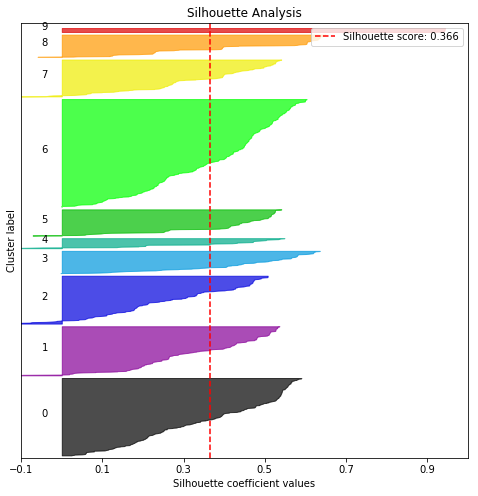

In [28]:
skplt.metrics.plot_silhouette(X,kmeans_labels,figsize=(8,8));

In [29]:
kmeans_cluster_centers[0]

array([ 31.22664066, 121.40758922])

#### Clustering Plot
In the plot, every color stands a cluster, the black star stands one cluster centroid. From the methodology of K-Means and also the plot, we know it regards the center of data points as the center of the corresponding cluster. However, it is not very proper in our business context, because we want most popular place, rather than most central place.

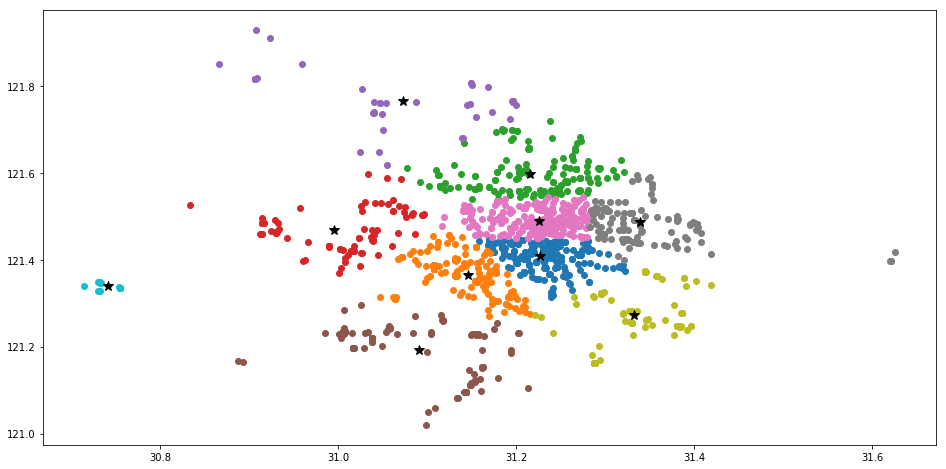

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(kmeans_n_clusters):
    #print('cluster ', i, 'all samples:')
    one_cluster = X[kmeans_labels == i]
    #print(one_cluster)
    plt.plot(one_cluster.lat,one_cluster.long,'o')
    plt.plot(kmeans_cluster_centers[i][0],kmeans_cluster_centers[i][1],'*',color='black',markersize=10)
    

plt.show()

#### Clustering Map
In the map, every color stands a cluster centroid. According to my experience, those points are just near popular business places, they are not popular themselves. This outcome also reflects the defect we analysis from the clustering plot and its methodology. Therefore, to synchronies with business, I try another clustering algorithm, DBSCAN, which is based on density. 

In [31]:
pois_map = folium.Map(location=[latitude, longitude],zoom_start=10) # zoom_start control the scale

add_markers(data_store,'grey',radius=1)

add_clusters(data_all,kmeans_labels,kmeans_cluster_centers)

# display map
pois_map

## 4.2 DBSCAN <a name="DBSCAN"></a>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html

The DBSCAN class has many parameters that can be used, but we will use these two:
<ul>
    <li> <strong>epsfloat</strong>: default=0.5 </li>
    <ul>
        <li> The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.</li>
    </ul>
    <li> <strong>min_samplesint</strong>: default=5 </li>
    <ul>
        <li> The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.</li>
    </ul>
</ul>

In [32]:
dbscan = DBSCAN(eps=0.008, 
                min_samples=20)

In [33]:
dbscan.fit(X)
dbscan_labels = dbscan.labels_
dbscan_n_clusters=len(set(dbscan_labels))- (1 if -1 in dbscan_labels else 0)  

dbscan_cluster_centers=[]
for i in range(dbscan_n_clusters):
    one_cluster = X[dbscan_labels == i]
    lat= one_cluster.lat.mean()
    long= one_cluster.long.mean()
    dbscan_cluster_centers.append([lat,long])
dbscan_cluster_centers=np.array(dbscan_cluster_centers)

In [34]:
dbscan_core_data_all=data_all.iloc[dbscan.core_sample_indices_,:]
dbscan_core_lables=dbscan_labels[dbscan.core_sample_indices_]

In [35]:
noise_ratio = sum((dbscan_labels==-1).astype(int)) / len(dbscan_labels)

In [36]:
dbscan_score=metrics.silhouette_score(X[dbscan_labels != -1],dbscan_labels[dbscan_labels != -1])

In [37]:
print('n_clusters:{:}\nnoise_ratio:{:.2%}\nsilhouette_score:{:.4f}'.format(dbscan_n_clusters,noise_ratio,dbscan_score))

n_clusters:13
noise_ratio:74.79%
silhouette_score:0.6970


#### Silhouette Plot
I set the maximum distance between two samples is 0.008 and minimum samples is 10. In the DBSCAN outcome, the Number of Clusters is 10. While the noise ratio is 80.33%, which means there are lots of data points are noises. Maybe those points are in low density, which means those places are not popular enough.

Apart from those noises, the Silhouette Plot seems very nice.

In [38]:
plt.metrics.plot_silhouette(X[dbscan_labels != -1],dbscan_labels[dbscan_labels != -1],figsize=(8,10));

AttributeError: module 'matplotlib.pyplot' has no attribute 'metrics'

#### Clustering Plot
In the plot, every color stands a cluster, except the grey ones, which stands for noises. And The black star stands one cluster centroid. The centroid is not the direct output of DBSCAN, but the average location of points in each cluster calculated by myself. 
From the methodology of DBSCAN and also the plot, we know it considers the data which is in the region with high density of the data space to belong to the same cluster. And that is fit our business logic, to find the most popular place.


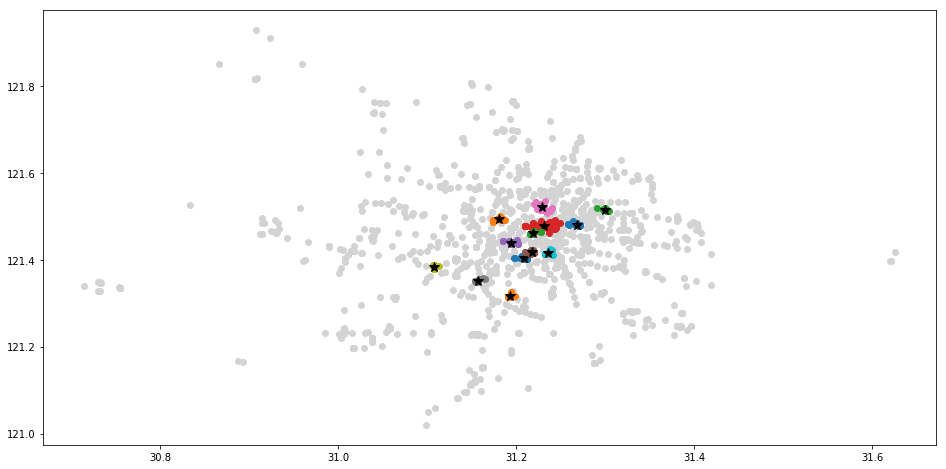

In [39]:
fig, ax = plt.subplots(figsize=(16, 8))

noise= X[dbscan_labels == -1]
plt.plot(noise.lat,noise.long,'o',color='lightgrey')

for i in range(dbscan_n_clusters):
    #print('cluster ', i, 'all samples:')
    one_cluster = X[dbscan_labels == i]
    #print(one_cluster)
    plt.plot(one_cluster.lat,one_cluster.long,'o')
    plt.plot(dbscan_cluster_centers[i][0],dbscan_cluster_centers[i][1],'*',color='black',markersize=10)

plt.show()

#### Clustering Map
In the map, every color stands a cluster centroid. Compared to the K-Means clustering map, those points are more central. And according to my experience, those points are very popular business places. This outcome also reconciles foregoing analysis.


In [40]:
pois_map = folium.Map(location=[latitude, longitude],zoom_start=10) # zoom_start control the scale

add_markers(data_store,'grey',radius=1)
add_clusters(dbscan_core_data_all,dbscan_core_lables,dbscan_cluster_centers)

# display map
pois_map

## 4.3 Conclusion <a name="conclusion"></a>

Based on those analysis, we finally use the clustering outcome of DBSCAN as top 10 popular places in Shanghai that fit our business. 

# 5. Final Results <a name="results"></a>

<b>Rank those popular Locations and find Nearby Malls</b>

We use shopping malls data near the top 10 popular places as a list of possible shopping malls to contact to open store. We also use the number of those malls as a popularity ranking standard. The place with most nearby shopping malls is the place the company should open its first store, because of its popularity. 

We get nearby shopping mall data from foursqure API: https://developer.foursquare.com

In [41]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#### Getting nearby shopping mall data from foursquare

In [42]:
CLIENT_ID=list(key_all[key_all['API']=='foursquare']['Username'])
CLIENT_ID=CLIENT_ID[0]

CLIENT_SECRET=list(key_all[key_all['API']=='foursquare']['Key'])
CLIENT_SECRET=CLIENT_SECRET[0]

VERSION = '20200401' # Foursquare API version

In [43]:
def getNearbyVenues(names, locations, radius=1000):
    
    venues_list=[]
    for name, loc in zip(names, locations):
            
        # create the API request URL
        query='Shopping Mall'
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            loc[0], 
            loc[1], 
            radius, 
            query)
        # make the GET request
        results = requests.get(url).json()["response"]['venues']       
        # return only relevant information for each nearby venue
        if len(results)>0:
            venues_list.append([(
                name, 
                loc[0], 
                loc[1], 
                result['name'], 
                result['id'],
                result['location']['lat'], 
                result['location']['lng'],
                result['location']['distance']) for result in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
         'Center', 
         'Center Latitude',     
         'Center Longitude', 
         'Venue', 
         'Venue Id',
         'Venue Latitude', 
         'Venue Longitude',
         'Distince from the Center']
    
    return(nearby_venues)

In [44]:
nearby_venues=getNearbyVenues(list(range(dbscan_n_clusters)),dbscan_cluster_centers)

#### Clean shopping mall data

In [45]:
nearby_venues_filtered=[]
for i in range(len(nearby_venues)):
    venue=nearby_venues.loc[i,'Venue']
    if pd.Series(['Mall','mall','Shopping','shopping','Plaza','Plaza']).map(lambda x: x in venue).any():
        nearby_venues_filtered.append(nearby_venues.loc[i]) 
nearby_venues_filtered=pd.DataFrame(nearby_venues_filtered)
nearby_venues_filtered.head()

Center  Center Latitude  Center Longitude                          Venue  \
0       0        31.208307        121.404978         Arch Walk Mall (金虹桥商场)   
1       0        31.208307        121.404978  JSWB Furniture Mall (吉盛伟邦家具城)   
3       0        31.208307        121.404978      New Hongqiao Mall (新虹桥商厦)   
4       0        31.208307        121.404978              Parkson Mall (百盛)   
5       0        31.208307        121.404978                 Furniture mall   

                   Venue Id  Venue Latitude  Venue Longitude  \
0  541d2de3498e20054632538e       31.208915       121.402491   
1  4e5ed60fb9935b74e9043c8d       31.205731       121.398122   
3  52ad793911d227be9da0e64b       31.207630       121.398931   
4  4e64b98e483bd9a9754a5dcf       31.212434       121.399205   
5  5275e42711d20efbe4bf54f9       31.205464       121.397879   

   Distince from the Center  
0                       246  
1                       712  
3                       580  
4                       716  
5                       746

#### Rank the best locations according to number of nearby shopping malls

In [46]:
dbscan_cluster_rank=nearby_venues_filtered.groupby(['Center'])['Venue'].count().sort_values(ascending=False).index
dbscan_cluster_centers_ranked=dbscan_cluster_centers[dbscan_cluster_rank]

#### Final Result

Every point stands for recommended store open locations. The radius stands for ranking. The biggest point is the recommended first store to open. And the words popup is the relevant shopping malls nearby to open the store. The company’s managers can then visit those shopping malls to evaluate their popularity and quality and contact those shopping malls to negotiate the price.

In [47]:
pois_map = folium.Map(location=[latitude, longitude],zoom_start=12) # zoom_start control the scale

rank=0
for loc in dbscan_cluster_centers_ranked:     
    rcmd_mall=', '.join(list(nearby_venues_filtered[nearby_venues_filtered['Center']==dbscan_cluster_rank[rank]].Venue))
    label = folium.Popup('Rank:'+str(rank)+'--'+rcmd_mall, parse_html=True)
    folium.features.CircleMarker(
        [loc[0], loc[1]],
        radius=10-(rank),
        popup=label,
        fill=True,
        color='orange',
        fill_color='red',
        fill_opacity=1-(rank)/10
        ).add_to(pois_map)
    rank+=1

# display map
pois_map